In [1]:
#!pip install keras
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np # linear algebra
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import math   
from datetime import datetime, date 
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

print("Setup Complete")

Setup Complete


In [9]:
#모델불러오기
dam = pd.read_csv('./data/다목적댐 데이터/보령댐_일별.csv', encoding= 'cp949', thousands=',')
dam.head()

,일시,댐수위(ELm),강우량(mm),유입량(㎡/sec),총방류량(㎡/sec),저수량(백만㎥/sec),저수율(%)
0,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.3
1,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.3
2,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.2
3,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.1
4,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.0


In [10]:
jsj = pd.read_csv('./정수장.csv', encoding= 'utf-8', thousands=',')
jsj

,Date,데이터값
0,2015-01-01,188112
1,2015-01-02,182624
2,2015-01-03,182256
3,2015-01-04,185216
4,2015-01-05,178848
...,...,...
3108,2023-07-06,260224
3109,2023-07-07,258240
3110,2023-07-08,255936
3111,2023-07-09,251776


In [11]:
jsj = jsj.rename(columns={
    'Date': 'date',
    '데이터값': 'jsj_flow'
})

In [12]:
dam.columns = ['date', 'water_level', 'rainfall', 'inflow', 'outflow', 'storage', 'storage_rate']
dam.head()

,date,water_level,rainfall,inflow,outflow,storage,storage_rate
0,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.3
1,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.3
2,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.2
3,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.1
4,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.0


In [6]:
dam = dam.merge(jsj[['date', 'jsj_flow']], on='date', how='left')

In [13]:
#결측값 확인
print(dam.isnull().sum())

date            0
water_level     0
rainfall        3
inflow          0
outflow         0
storage         0
storage_rate    0
dtype: int64


In [14]:
dam=dam.interpolate()

In [17]:
#숫자로 변환 (필요할 경우 사용)
dam['inflow'] = pd.to_numeric(dam['inflow'],errors='coerce')

In [18]:
dam.describe()

,water_level,rainfall,inflow,outflow,storage,storage_rate
count,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000
mean,63.836513,3.747102,3.957829,3.880179,44.497528,38.068655
std,4.468232,14.417918,15.275968,11.291775,17.339779,14.833018
min,52.160000,0.000000,0.000000,1.600000,9.690000,8.300000
25%,61.080000,0.000000,0.700000,2.700000,32.880000,28.110000
50%,63.130000,0.000000,1.500000,3.100000,40.300000,34.500000
75%,65.915000,0.400000,2.700000,3.400000,51.870000,44.400000
max,73.910000,293.000000,476.400000,535.900000,88.220000,75.500000


In [19]:
dam = dam.reset_index(drop=True)

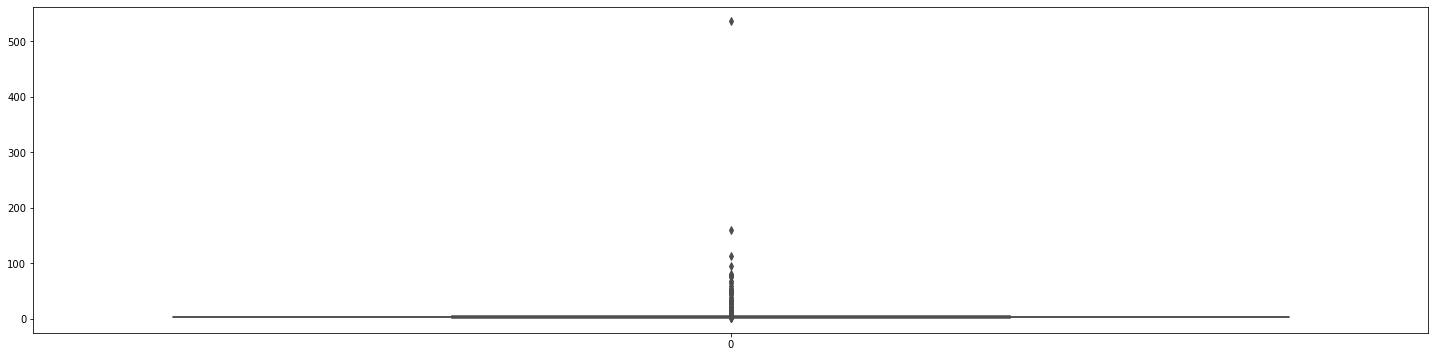

In [20]:
plt.figure(figsize=(25,6))
sns.boxplot(data=dam['outflow'], color='red')
plt.show()

In [21]:
#remove outlier

Q1 = dam['outflow'].quantile(0.25)
Q3 = dam['outflow'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range.

filter = (dam['outflow'] >= Q1 - 1.5 * IQR) & (dam['outflow'] <= Q3 + 1.5 *IQR)
dam = dam.loc[filter]
print(dam['outflow'].describe())
print('\n')
print(dam['outflow'].describe())

count    3051.000000
mean        3.047886
std         0.486329
min         1.700000
25%         2.700000
50%         3.100000
75%         3.400000
max         4.400000
Name: outflow, dtype: float64


count    3051.000000
mean        3.047886
std         0.486329
min         1.700000
25%         2.700000
50%         3.100000
75%         3.400000
max         4.400000
Name: outflow, dtype: float64


In [22]:
dam = dam.reset_index(drop=True)

In [3]:
dam.columns = ['date', 'water_level', 'rainfall', 'inflow', 'outflow', 'storage', 'storage_rate']
dam.head()

,date,water_level,rainfall,inflow,outflow,storage,storage_rate
0,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.3
1,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.3
2,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.2
3,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.1
4,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.0


In [23]:
dam = dam.merge(jsj[['date', 'jsj_flow']], on='date', how='left')

In [24]:
dam

,date,water_level,rainfall,inflow,outflow,storage,storage_rate,jsj_flow
0,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.30,188112
1,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.30,182624
2,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.20,182256
3,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.10,185216
4,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.00,178848
...,...,...,...,...,...,...,...,...
3046,2023-07-06,65.35,0.0,18.5,3.2,48.06,41.12,260224
3047,2023-07-07,66.05,57.8,35.3,3.2,50.84,43.49,258240
3048,2023-07-08,66.68,0.0,32.6,3.2,53.38,45.66,255936
3049,2023-07-09,66.94,0.0,15.3,3.2,54.42,46.56,251776


# 시간(날짜) 데이터 처리

In [23]:
dam["date"] = pd.to_datetime(dam["date"])
dam.index = dam["date"]

In [24]:
dam.head()

,date,water_level,rainfall,inflow,outflow,storage,storage_rate
date,,,,,,,
2015-01-01,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.3
2015-01-02,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.3
2015-01-03,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.2
2015-01-04,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.1
2015-01-05,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.0


# 데이터 시각화

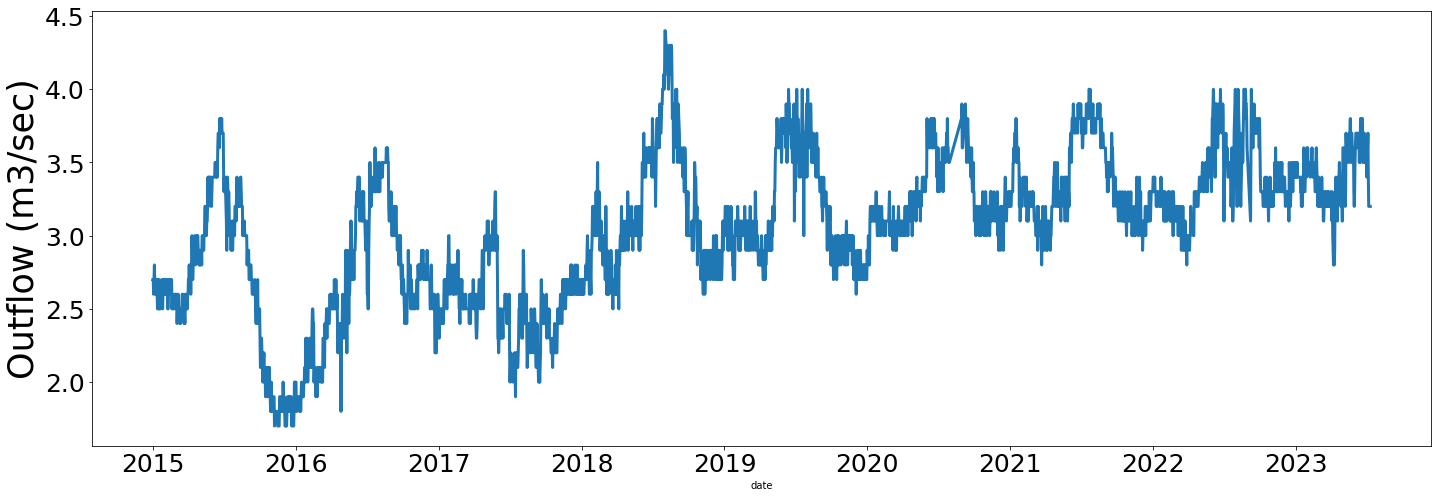

In [25]:
plt.figure(figsize=(24,8))

dam_o = sns.lineplot(data=dam['outflow'], linewidth=3)
plt.ylabel('Outflow (m3/sec)',fontsize =35)
plt.xticks(fontsize =25)
plt.yticks(fontsize =25)
#plt.grid(True)  
dam_o.xaxis.set_major_locator(mdates.YearLocator())
dam_o.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

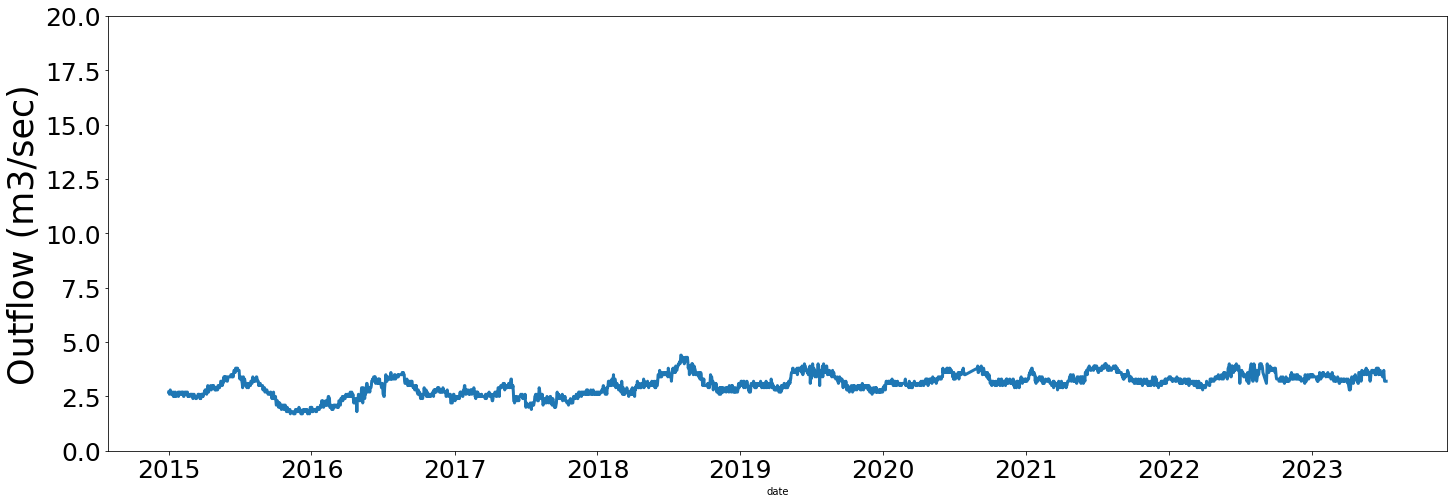

In [26]:
plt.figure(figsize=(24,8))

dam_o = sns.lineplot(data=dam['outflow'], linewidth=3)
plt.ylabel('Outflow (m3/sec)',fontsize =35)
plt.xticks(fontsize =25)
plt.yticks(fontsize =25)
plt.ylim(0,20)
#plt.grid(True)  
dam_o.xaxis.set_major_locator(mdates.YearLocator())
dam_o.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

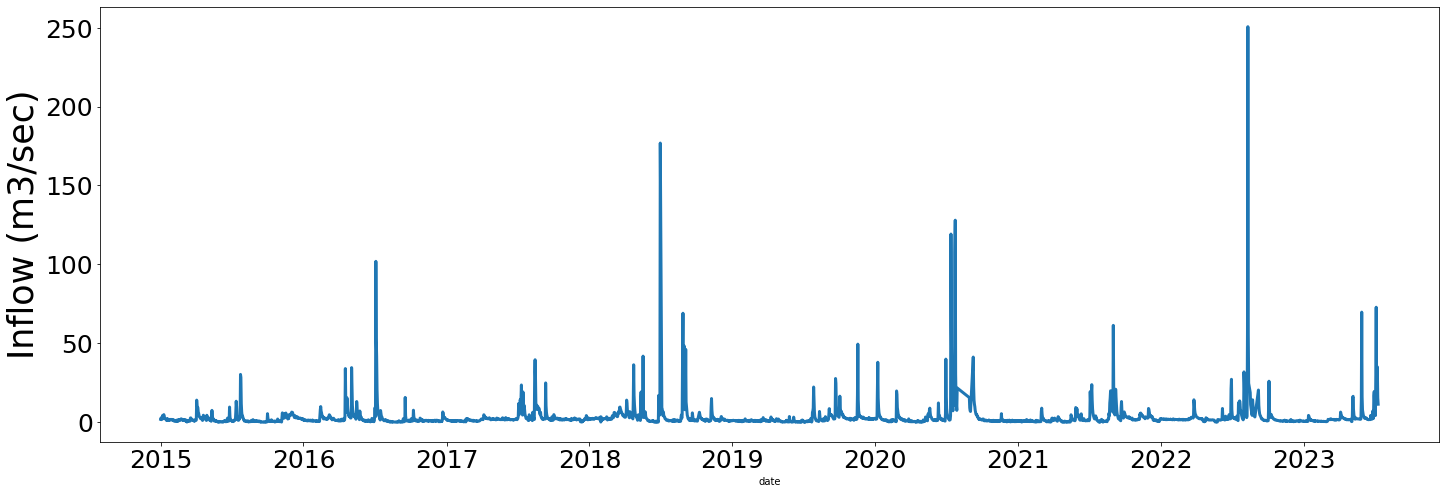

In [27]:
plt.figure(figsize=(24,8))

dam_o = sns.lineplot(data=dam['inflow'], linewidth=3)
plt.ylabel('Inflow (m3/sec)',fontsize =35)
plt.xticks(fontsize =25)
plt.yticks(fontsize =25)
#plt.grid(True)  
dam_o.xaxis.set_major_locator(mdates.YearLocator())
dam_o.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

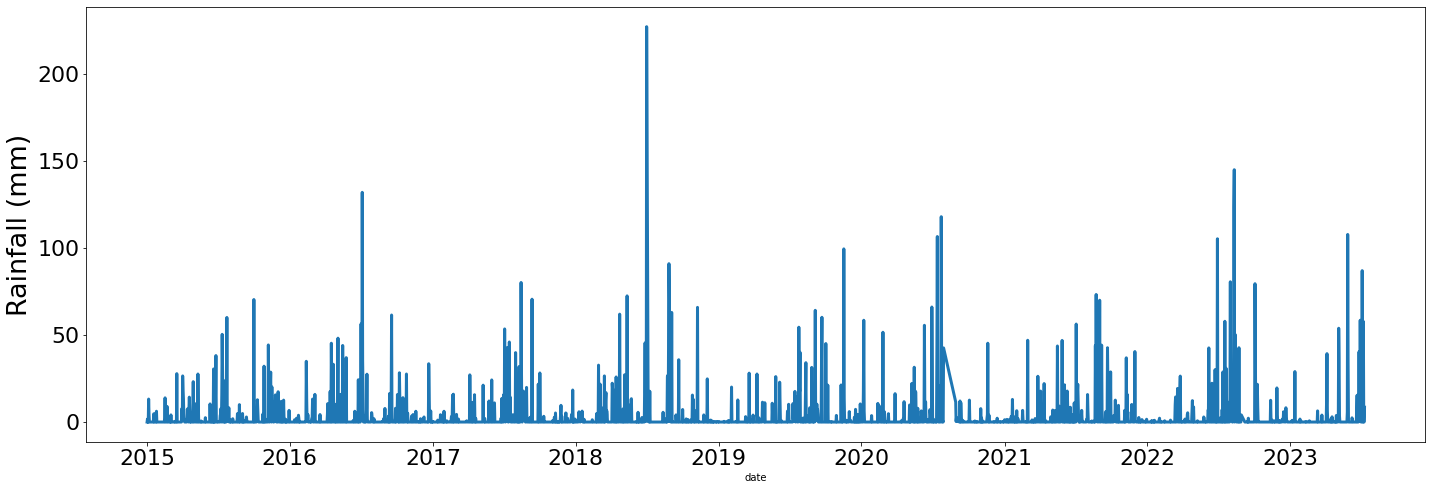

In [28]:
plt.figure(figsize=(24,8))

dam_o = sns.lineplot(data=dam['rainfall'], linewidth=3)
plt.ylabel('Rainfall (mm)',fontsize =27)
plt.xticks(fontsize =22)
plt.yticks(fontsize =22)
#plt.grid(True)  
dam_o.xaxis.set_major_locator(mdates.YearLocator())
dam_o.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

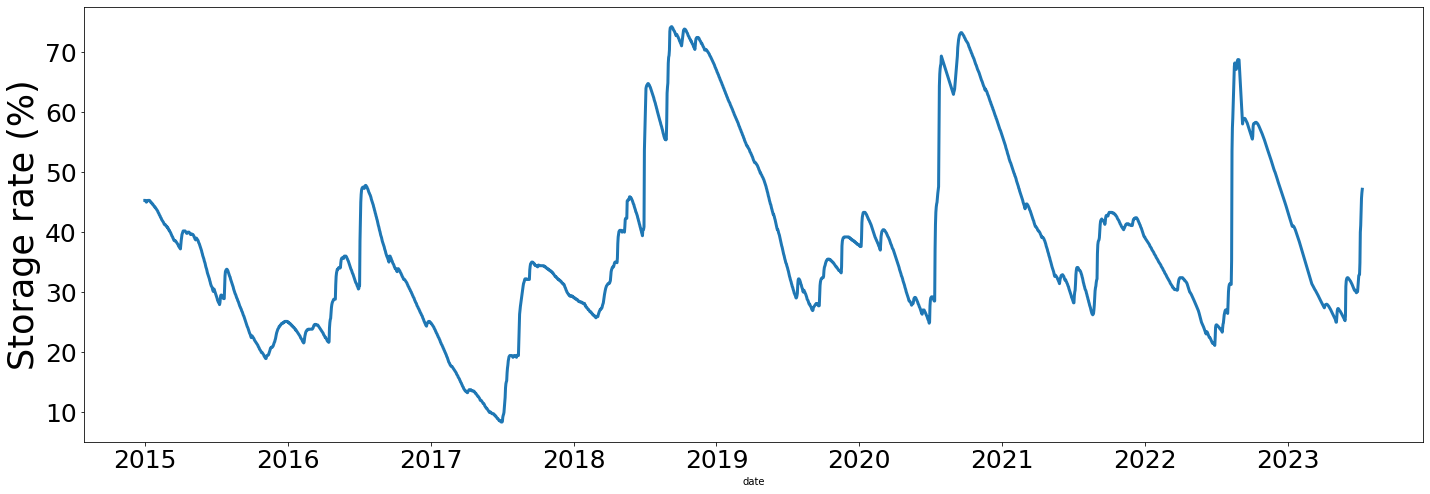

In [29]:
plt.figure(figsize=(24,8))

dam_o = sns.lineplot(data=dam['storage_rate'], linewidth=3)
plt.ylabel('Storage rate (%)',fontsize =35)
plt.xticks(fontsize =25)
plt.yticks(fontsize =25)
#plt.grid(True)  
dam_o.xaxis.set_major_locator(mdates.YearLocator())
dam_o.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

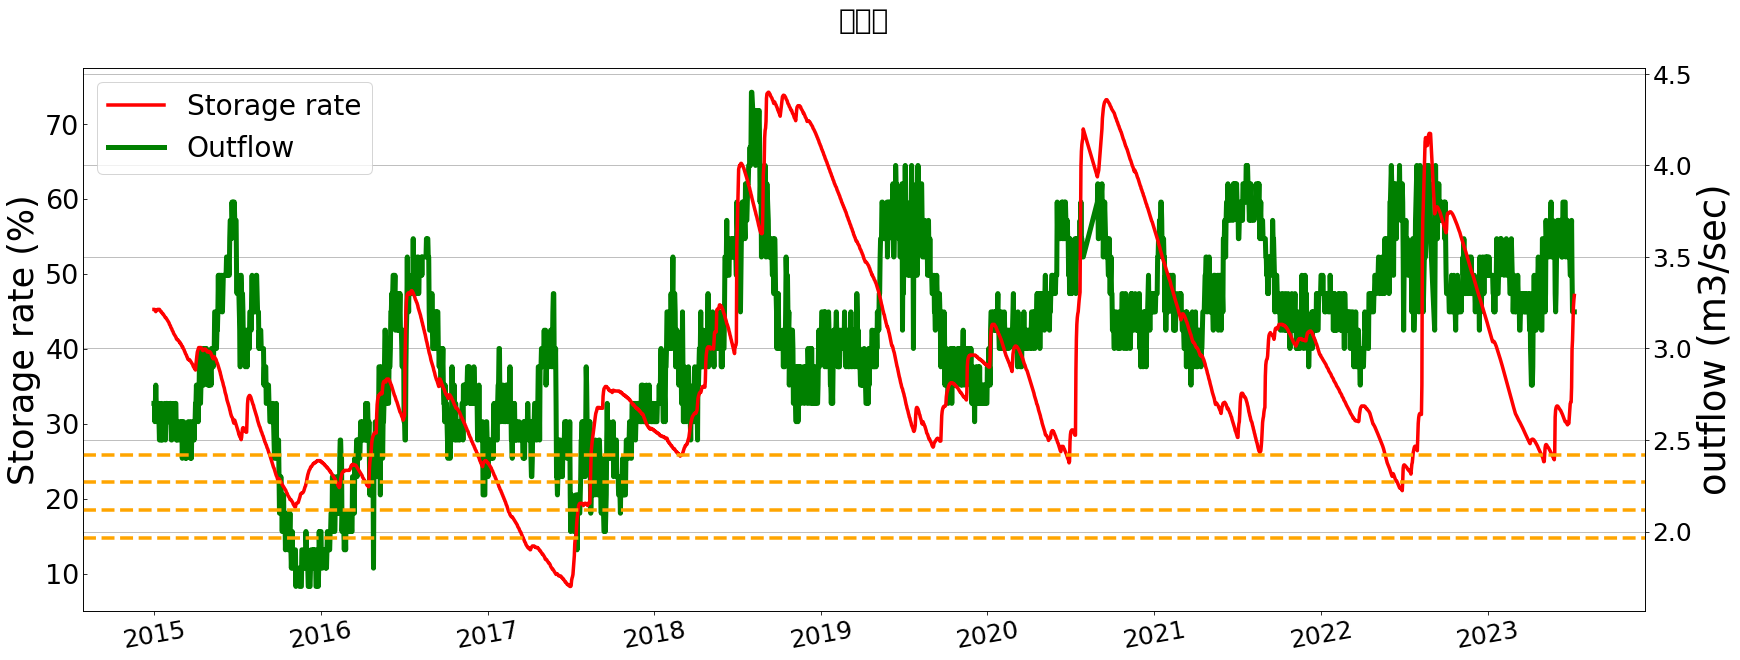

In [30]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (28,10)
#plt.rcParams['font.size'] = 18

fig, ax1 = plt.subplots()
ax1.plot(dam['storage_rate'], label='Storage rate', color='r', linewidth=3.5)
ax1.axhline(y=25.9, color='orange', linestyle='--', linewidth=3.5)  # 70% 선
ax1.axhline(y=22.2, color='orange', linestyle='--', linewidth=3.5)  # 60% 선
ax1.axhline(y=18.5, color='orange', linestyle='--', linewidth=3.5)  # 50% 선
ax1.axhline(y=14.8, color='orange', linestyle='--', linewidth=3.5)  # 40% 선

ax1.set_ylabel('Storage rate (%)', fontsize=35)
ax1.tick_params(axis='y', direction='in', labelsize=27)
ax1.tick_params(axis='x', rotation=10, labelsize=25)

ax2 = ax1.twinx()
ax2.plot(dam['outflow'], label='Outflow', color='g', linewidth=5)
ax2.set_ylabel('outflow (m3/sec)', fontsize=37)
ax2.tick_params(axis='y', labelsize=25)

ax1.set_title('보령댐\n', fontsize=28)
plt.xticks(fontsize=23)
plt.yticks(fontsize=25)
plt.grid(True)

# 범례 추가
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=28)

ax1.set_zorder(ax1.get_zorder() + 10)
ax1.patch.set_visible(False)

plt.show()

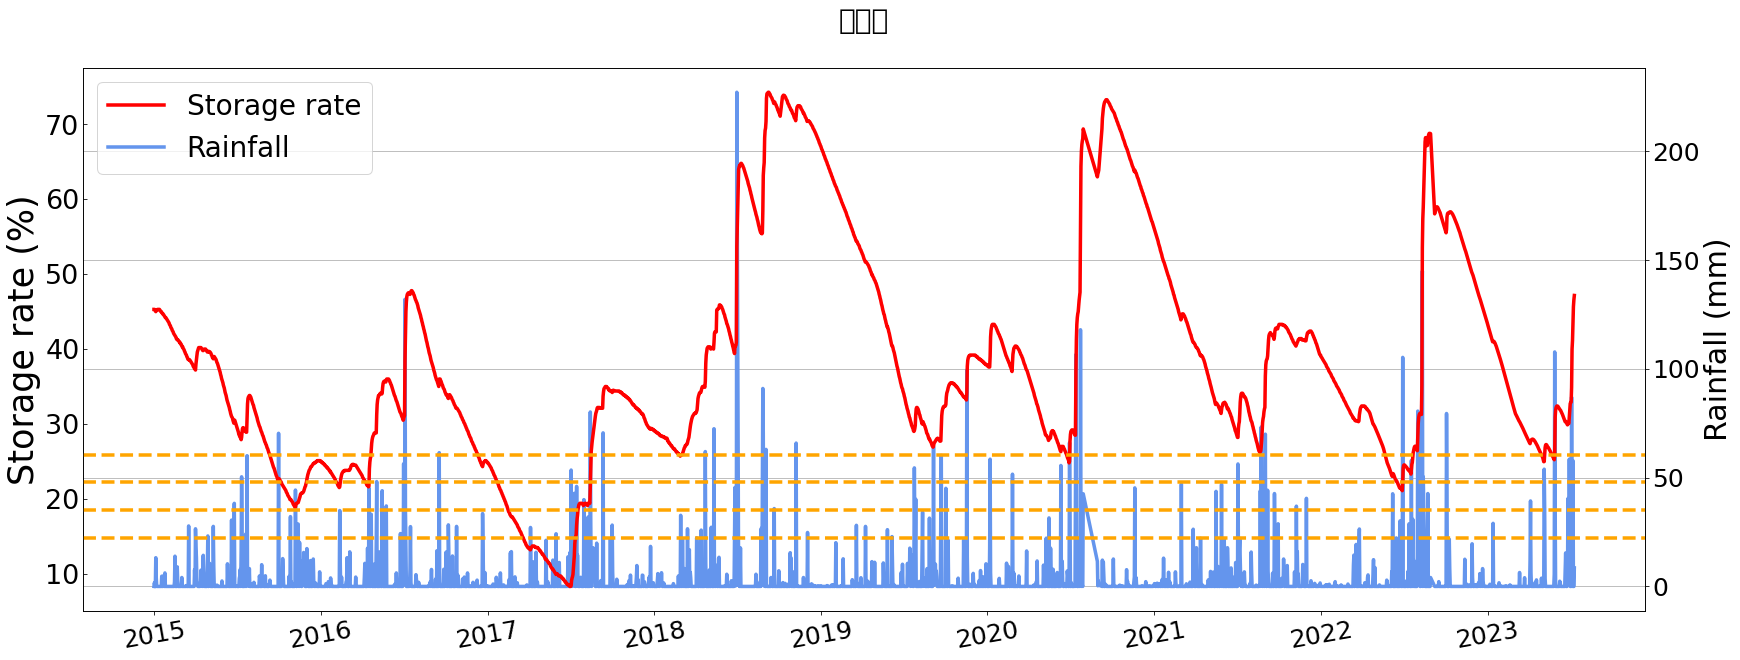

In [31]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (28, 10)
#plt.rcParams['font.size'] = 18

fig, ax1 = plt.subplots()
ax1.plot(dam['storage_rate'], label='Storage rate', color='r', linewidth=3.5)
ax1.axhline(y=25.9, color='orange', linestyle='--', linewidth=3.5)  # 70% 선
ax1.axhline(y=22.2, color='orange', linestyle='--', linewidth=3.5)  # 60% 선
ax1.axhline(y=18.5, color='orange', linestyle='--', linewidth=3.5)  # 50% 선
ax1.axhline(y=14.8, color='orange', linestyle='--', linewidth=3.5)  # 40% 선

ax1.set_ylabel('Storage rate (%)', fontsize=35)
ax1.tick_params(axis='y', direction='in', labelsize=27)
ax1.tick_params(axis='x', rotation=10, labelsize=25)

ax2 = ax1.twinx()
ax2.plot(dam['rainfall'], label='Rainfall', color='cornflowerblue', linewidth=3.5)
ax2.set_ylabel('Rainfall (mm)', fontsize=30)
ax2.tick_params(axis='y', labelsize=27)

ax1.set_title('보령댐\n', fontsize=28)
plt.xticks(fontsize=23)
plt.yticks(fontsize=25)
plt.grid(True)

# 범례 추가
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=28)

ax1.set_zorder(ax1.get_zorder() + 10)
ax1.patch.set_visible(False)

plt.show()

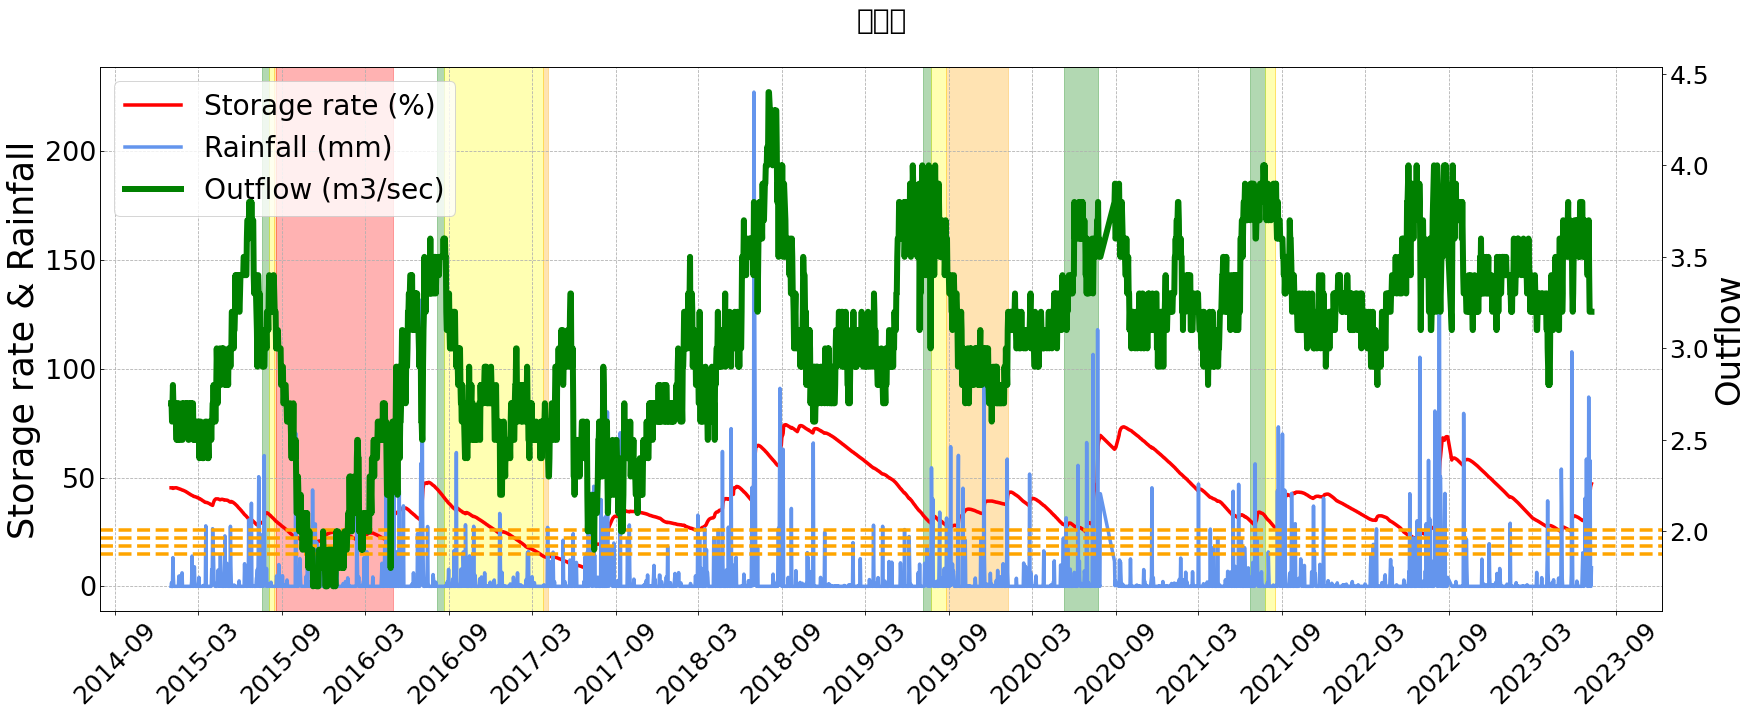

In [32]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (28, 10)
#plt.rcParams['font.size'] = 18

fig, ax1 = plt.subplots()
ax1.plot(dam['storage_rate'], label='Storage rate (%)', color='r', linewidth=3.5)
ax1.plot(dam['rainfall'], label='Rainfall (mm)', color='cornflowerblue', linewidth=3.5)
ax1.axhline(y=25.9, color='orange', linestyle='--', linewidth=3.5)  # 70% 선
ax1.axhline(y=22.2, color='orange', linestyle='--', linewidth=3.5)  # 60% 선
ax1.axhline(y=18.5, color='orange', linestyle='--', linewidth=3.5)  # 50% 선
ax1.axhline(y=14.8, color='orange', linestyle='--', linewidth=3.5)  # 40% 선

ax1.set_ylabel('Storage rate & Rainfall', fontsize=35)
ax1.tick_params(axis='y', direction='in', labelsize=27)
ax1.tick_params(axis='x', rotation=45, labelsize=25)

ax2 = ax1.twinx()
ax2.plot(dam['outflow'], label='Outflow (m3/sec)', color='g', linewidth=6)
ax2.set_ylabel('Outflow', fontsize=34)
ax2.tick_params(axis='y', labelsize=27)

ax1.set_title('보령댐\n', fontsize=28)
plt.xticks(fontsize=23)
plt.yticks(fontsize=25)
#plt.grid(True)

# 가로세로 그리드 그리기
ax1.grid(which='both', linestyle='--')

# 1
date_range_start = '2015-07-20'
date_range_end = '2015-08-04'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='green')
# 특정 기간 백그라운드 색 나타내기
date_range_start = '2015-08-04'
date_range_end = '2015-08-15'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='yellow')
# 특정 기간 백그라운드 색 나타내기
date_range_start = '2015-08-15'
date_range_end = '2015-08-18'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='orange')
# 특정 기간 백그라운드 색 나타내기
date_range_start = '2015-08-18'
date_range_end = '2016-05-01'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='red')

# 2
date_range_start = '2016-08-06'
date_range_end = '2016-08-21'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='green')
# 특정 기간 백그라운드 색 나타내기
date_range_start = '2016-08-21'
date_range_end = '2017-03-25'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='yellow')
# 특정 기간 백그라운드 색 나타내기
date_range_start = '2017-03-25'
date_range_end = '2017-04-06'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='orange')

# 3
date_range_start = '2019-07-07'
date_range_end = '2019-07-24'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='green')
# 특정 기간 백그라운드 색 나타내기
date_range_start = '2019-07-24'
date_range_end = '2019-08-26'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='yellow')
# 특정 기간 백그라운드 색 나타내기
date_range_start = '2019-08-26'
date_range_end = '2020-01-08'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='orange')

# 4
date_range_start = '2020-05-10'
date_range_end = '2020-07-23'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='green')

#5
date_range_start = '2021-06-21'
date_range_end = '2021-07-25'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='green')
# 특정 기간 백그라운드 색 나타내기
date_range_start = '2021-07-25'
date_range_end = '2021-08-16'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='yellow')
# 특정 기간 백그라운드 색 나타내기
date_range_start = '2021-08-16'
date_range_start = '2021-08-16'
ax1.axvspan(date_range_start, date_range_end, alpha=0.3, color='orange')

# 범례 추가
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=28)

# x축 날짜 포맷팅 - 모든 월 표시
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
date_formatter = mdates.DateFormatter("%Y-%m")
ax1.xaxis.set_major_formatter(date_formatter)

#ax1.set_zorder(ax1.get_zorder() + 10)
#ax1.patch.set_visible(False)

plt.show()

# 데이터 정규화 Normalization

데이터의 범위를 0에서 1로 변경하여 데이터 값들의 편차를 줄임

In [25]:
dam

,date,water_level,rainfall,inflow,outflow,storage,storage_rate,jsj_flow
0,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.30,188112
1,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.30,182624
2,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.20,182256
3,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.10,185216
4,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.00,178848
...,...,...,...,...,...,...,...,...
3046,2023-07-06,65.35,0.0,18.5,3.2,48.06,41.12,260224
3047,2023-07-07,66.05,57.8,35.3,3.2,50.84,43.49,258240
3048,2023-07-08,66.68,0.0,32.6,3.2,53.38,45.66,255936
3049,2023-07-09,66.94,0.0,15.3,3.2,54.42,46.56,251776


In [26]:
features = dam[['rainfall', 'inflow', 'outflow', 'storage', 'storage_rate', 'jsj_flow']]
print(features)

      rainfall  inflow  outflow  storage  storage_rate  jsj_flow
0          0.0     1.7      2.7    52.91         45.30    188112
1          1.7     2.7      2.7    52.91         45.30    182624
2          0.0     1.6      2.6    52.83         45.20    182256
3          0.0     1.7      2.7    52.74         45.10    185216
4         13.2     1.8      2.8    52.65         45.00    178848
...        ...     ...      ...      ...           ...       ...
3046       0.0    18.5      3.2    48.06         41.12    260224
3047      57.8    35.3      3.2    50.84         43.49    258240
3048       0.0    32.6      3.2    53.38         45.66    255936
3049       0.0    15.3      3.2    54.42         46.56    251776
3050       8.5    11.3      3.2    55.13         47.16    249664

[3051 rows x 6 columns]


In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaler.fit(features)
dam_scaled=scaler.transform(features)

dam_scaled=pd.DataFrame(data=dam_scaled, columns=list(features))
print('feature 최솟값')
print(dam_scaled.min())
print('\n''fearure 최댓값')
print(dam_scaled.max())

feature 최솟값
rainfall        0.0
inflow          0.0
outflow         0.0
storage         0.0
storage_rate    0.0
jsj_flow        0.0
dtype: float64

fearure 최댓값
rainfall        1.0
inflow          1.0
outflow         1.0
storage         1.0
storage_rate    1.0
jsj_flow        1.0
dtype: float64


# 입력 변수의 관계를 이용하여  저수량 변화를 계산: Rainfall + Inflow - Outflow

In [28]:
dam['variation'] = 0
for i, idx in enumerate(dam.index):
    dam.loc[idx, 'variation'] = dam_scaled['rainfall'][i]+dam_scaled['inflow'][i]-dam_scaled['outflow'][i]

In [29]:
dam_scaled

,rainfall,inflow,outflow,storage,storage_rate,jsj_flow
0,0.000000,0.006781,0.370370,0.559845,0.560606,0.228393
1,0.007482,0.010770,0.370370,0.559845,0.560606,0.211814
2,0.000000,0.006382,0.333333,0.558808,0.559091,0.210702
3,0.000000,0.006781,0.370370,0.557642,0.557576,0.219644
4,0.058099,0.007180,0.407407,0.556477,0.556061,0.200406
...,...,...,...,...,...,...
3046,0.000000,0.073793,0.555556,0.497021,0.497273,0.446249
3047,0.254401,0.140806,0.555556,0.533031,0.533182,0.440255
3048,0.000000,0.130036,0.555556,0.565933,0.566061,0.433295
3049,0.000000,0.061029,0.555556,0.579404,0.579697,0.420727


In [30]:
dam = dam.reset_index(drop=True)

In [31]:
df = dam['variation']
df

0      -0.363589
1      -0.352118
2      -0.326951
3      -0.363589
4      -0.342129
          ...   
3046   -0.481762
3047   -0.160348
3048   -0.425520
3049   -0.494526
3050   -0.473070
Name: variation, Length: 3051, dtype: float64

In [32]:
ds_list = []

for i in range(1,len(df)):
    ds = df[i]-df[i-1]
    ds_list.append(ds)
    
ds_dt = pd.DataFrame(ds_list)

In [33]:
ds_dt.columns = ['ds_dt']
print(ds_dt)

         ds_dt
0     0.011471
1     0.025167
2    -0.036638
3     0.021460
4     0.006557
...        ...
3045 -0.250354
3046  0.321414
3047 -0.265171
3048 -0.069007
3049  0.021457

[3050 rows x 1 columns]


In [34]:
ds_dt['ds_dt'] = pd.to_numeric(ds_dt['ds_dt'],errors='coerce')
print(ds_dt)

         ds_dt
0     0.011471
1     0.025167
2    -0.036638
3     0.021460
4     0.006557
...        ...
3045 -0.250354
3046  0.321414
3047 -0.265171
3048 -0.069007
3049  0.021457

[3050 rows x 1 columns]


In [35]:
dam = dam[1:]

In [36]:
dam_scaled = dam_scaled[1:]

In [37]:
dam = dam.reset_index(drop=True)
print(dam)

            date  water_level  rainfall  inflow  outflow  storage  \
0     2015-01-02        66.10       1.7     2.7      2.7    52.91   
1     2015-01-03        66.08       0.0     1.6      2.6    52.83   
2     2015-01-04        66.06       0.0     1.7      2.7    52.74   
3     2015-01-05        66.04      13.2     1.8      2.8    52.65   
4     2015-01-06        66.07       4.1     4.2      2.7    52.78   
...          ...          ...       ...     ...      ...      ...   
3045  2023-07-06        65.35       0.0    18.5      3.2    48.06   
3046  2023-07-07        66.05      57.8    35.3      3.2    50.84   
3047  2023-07-08        66.68       0.0    32.6      3.2    53.38   
3048  2023-07-09        66.94       0.0    15.3      3.2    54.42   
3049  2023-07-10        67.11       8.5    11.3      3.2    55.13   

      storage_rate  jsj_flow  variation  
0            45.30    182624  -0.352118  
1            45.20    182256  -0.326951  
2            45.10    185216  -0.363589  
3  

In [38]:
dam_scaled = dam_scaled.reset_index(drop=True)
print(dam_scaled)

      rainfall    inflow   outflow   storage  storage_rate  jsj_flow
0     0.007482  0.010770  0.370370  0.559845      0.560606  0.211814
1     0.000000  0.006382  0.333333  0.558808      0.559091  0.210702
2     0.000000  0.006781  0.370370  0.557642      0.557576  0.219644
3     0.058099  0.007180  0.407407  0.556477      0.556061  0.200406
4     0.018046  0.016753  0.370370  0.558161      0.559091  0.260247
...        ...       ...       ...       ...           ...       ...
3045  0.000000  0.073793  0.555556  0.497021      0.497273  0.446249
3046  0.254401  0.140806  0.555556  0.533031      0.533182  0.440255
3047  0.000000  0.130036  0.555556  0.565933      0.566061  0.433295
3048  0.000000  0.061029  0.555556  0.579404      0.579697  0.420727
3049  0.037412  0.045074  0.555556  0.588601      0.588788  0.414346

[3050 rows x 6 columns]


In [39]:
dam['ds_dt'] = ds_dt

In [40]:
dam_scaled['ds_dt'] = ds_dt
dam_scaled['obs_storage_rate'] = dam['storage_rate']

In [41]:
print(dam)

            date  water_level  rainfall  inflow  outflow  storage  \
0     2015-01-02        66.10       1.7     2.7      2.7    52.91   
1     2015-01-03        66.08       0.0     1.6      2.6    52.83   
2     2015-01-04        66.06       0.0     1.7      2.7    52.74   
3     2015-01-05        66.04      13.2     1.8      2.8    52.65   
4     2015-01-06        66.07       4.1     4.2      2.7    52.78   
...          ...          ...       ...     ...      ...      ...   
3045  2023-07-06        65.35       0.0    18.5      3.2    48.06   
3046  2023-07-07        66.05      57.8    35.3      3.2    50.84   
3047  2023-07-08        66.68       0.0    32.6      3.2    53.38   
3048  2023-07-09        66.94       0.0    15.3      3.2    54.42   
3049  2023-07-10        67.11       8.5    11.3      3.2    55.13   

      storage_rate  jsj_flow  variation     ds_dt  
0            45.30    182624  -0.352118  0.011471  
1            45.20    182256  -0.326951  0.025167  
2            45

In [42]:
print(dam_scaled)

      rainfall    inflow   outflow   storage  storage_rate  jsj_flow  \
0     0.007482  0.010770  0.370370  0.559845      0.560606  0.211814   
1     0.000000  0.006382  0.333333  0.558808      0.559091  0.210702   
2     0.000000  0.006781  0.370370  0.557642      0.557576  0.219644   
3     0.058099  0.007180  0.407407  0.556477      0.556061  0.200406   
4     0.018046  0.016753  0.370370  0.558161      0.559091  0.260247   
...        ...       ...       ...       ...           ...       ...   
3045  0.000000  0.073793  0.555556  0.497021      0.497273  0.446249   
3046  0.254401  0.140806  0.555556  0.533031      0.533182  0.440255   
3047  0.000000  0.130036  0.555556  0.565933      0.566061  0.433295   
3048  0.000000  0.061029  0.555556  0.579404      0.579697  0.420727   
3049  0.037412  0.045074  0.555556  0.588601      0.588788  0.414346   

         ds_dt  obs_storage_rate  
0     0.011471             45.30  
1     0.025167             45.20  
2    -0.036638             45.

In [43]:
dam["date"] = pd.to_datetime(dam["date"])

In [44]:
dam.index = dam["date"]

# 데이터 시각화

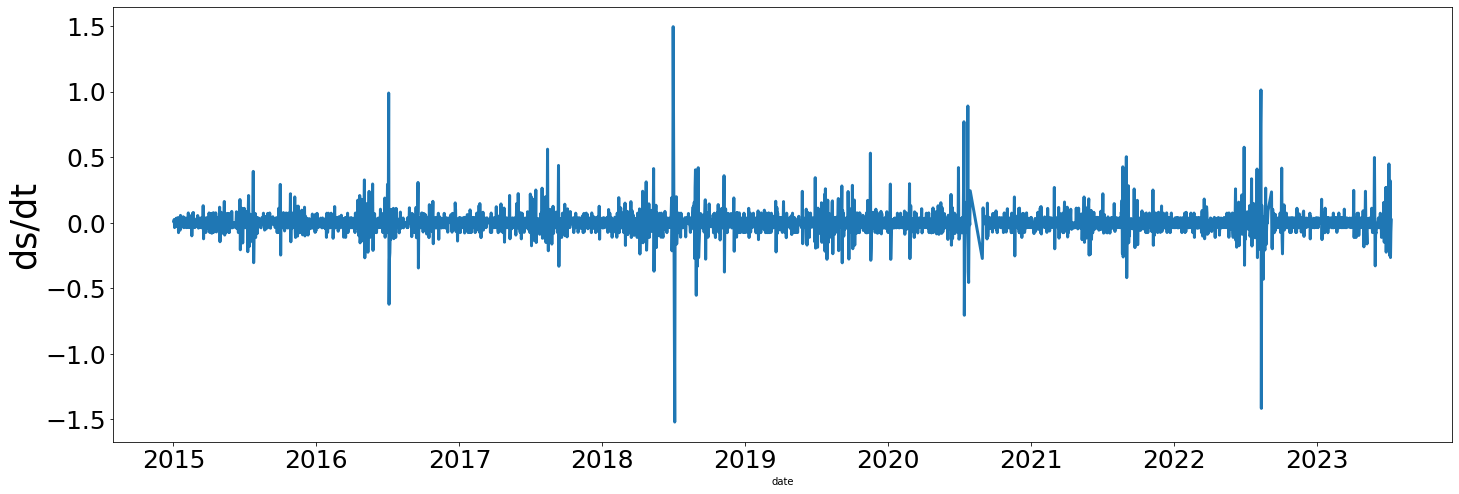

In [45]:
plt.figure(figsize=(24,8))

dam_o = sns.lineplot(data=dam['ds_dt'], linewidth=3)
plt.ylabel('ds/dt',fontsize = 35)
#plt.xlabel('Date', fontsize =17)
plt.xticks(fontsize =25)
plt.yticks(fontsize =25)
#plt.grid(True)
dam_o.xaxis.set_major_locator(mdates.YearLocator())
dam_o.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

<Figure size 432x288 with 0 Axes>

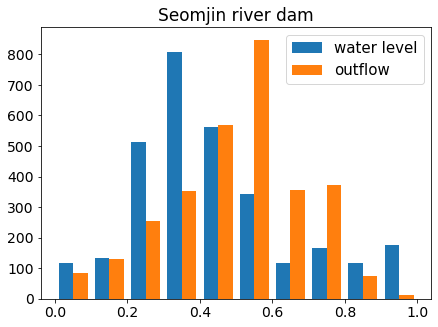

<Figure size 432x288 with 0 Axes>

In [46]:
plt.figure(figsize=(7,5))
plt.hist((dam_scaled.storage_rate, dam_scaled.outflow), histtype='bar', label=['water level','outflow']) 
plt.title('Seomjin river dam', fontsize = 17)
plt.legend(fontsize=15)
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)
plt.figure()

# 베이지안을 통해 최적화된 하이퍼파라미터를 적용하여 모델 학습 및 예측 수행

In [47]:
dam_scaled.describe()

,rainfall,inflow,outflow,storage,storage_rate,jsj_flow,ds_dt,obs_storage_rate
count,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000
mean,0.014099,0.012183,0.499259,0.441674,0.441834,0.322827,-0.000036,37.461033
std,0.051265,0.034584,0.180136,0.217717,0.217845,0.082769,0.102387,14.377790
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.519417,8.300000
25%,0.000000,0.002792,0.370370,0.298834,0.298485,0.267897,-0.037835,28.000000
50%,0.000000,0.005983,0.518519,0.393199,0.393485,0.333285,-0.000399,34.270000
75%,0.001761,0.009972,0.629630,0.529728,0.530303,0.386311,0.036638,43.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.495333,74.300000


In [49]:
dam_scaled.describe()

,rainfall,inflow,outflow,storage,storage_rate,jsj_flow,ds_dt,obs_storage_rate
count,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000
mean,0.014099,0.012183,0.499259,0.441674,0.441834,0.322827,-0.000036,37.461033
std,0.051265,0.034584,0.180136,0.217717,0.217845,0.082769,0.102387,14.377790
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.519417,8.300000
25%,0.000000,0.002792,0.370370,0.298834,0.298485,0.267897,-0.037835,28.000000
50%,0.000000,0.005983,0.518519,0.393199,0.393485,0.333285,-0.000399,34.270000
75%,0.001761,0.009972,0.629630,0.529728,0.530303,0.386311,0.036638,43.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.495333,74.300000


In [50]:
dam_scaled

,rainfall,inflow,outflow,storage,storage_rate,jsj_flow,ds_dt,obs_storage_rate
0,0.007482,0.010770,0.370370,0.559845,0.560606,0.211814,0.011471,45.30
1,0.000000,0.006382,0.333333,0.558808,0.559091,0.210702,0.025167,45.20
2,0.000000,0.006781,0.370370,0.557642,0.557576,0.219644,-0.036638,45.10
3,0.058099,0.007180,0.407407,0.556477,0.556061,0.200406,0.021460,45.00
4,0.018046,0.016753,0.370370,0.558161,0.559091,0.260247,0.006557,45.20
...,...,...,...,...,...,...,...,...
3045,0.000000,0.073793,0.555556,0.497021,0.497273,0.446249,-0.250354,41.12
3046,0.254401,0.140806,0.555556,0.533031,0.533182,0.440255,0.321414,43.49
3047,0.000000,0.130036,0.555556,0.565933,0.566061,0.433295,-0.265171,45.66
3048,0.000000,0.061029,0.555556,0.579404,0.579697,0.420727,-0.069007,46.56


In [51]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [52]:
print(dam_scaled.shape)


(3050, 8)


In [53]:
# 1. 필요한 라이브러리 임포트
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [54]:
# 2. SMAPE 함수 정의
def smape(A, F):
    return 100 * np.mean(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))



In [56]:
# 3. 데이터 준비 및 처리

# 가정: dam_scaled는 이미 정의된 DataFrame이며, 필요한 column들이 존재합니다.
features = ["rainfall", "inflow", "outflow", "ds_dt", "jsj_flow"]
output = "obs_storage_rate"

In [57]:
X = dam_scaled[features]
y = dam_scaled[output]

In [58]:
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [59]:
print(X_test.shape)

(610, 5)


In [60]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
from sklearn.model_selection import GridSearchCV

In [62]:
# 2. Hyperparameter tuning with 10-fold CV

# XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_search = GridSearchCV(XGBRegressor(), xgb_param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
xgb_search.fit(X_train_scaled, y_train)
xgb_model = xgb_search.best_estimator_

# LightGBM
lgbm_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 62, 93],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

lgbm_search = GridSearchCV(LGBMRegressor(verbose=-1), lgbm_param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
lgbm_search.fit(X_train_scaled, y_train)
lgbm_model = lgbm_search.best_estimator_

# CatBoost
cat_param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

cat_search = GridSearchCV(CatBoostRegressor(verbose=0), cat_param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
cat_search.fit(X_train_scaled, y_train)
catboost_model = cat_search.best_estimator_

# Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_search = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
rf_search.fit(X_train_scaled, y_train)
rf_model = rf_search.best_estimator_

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
Fitting 10 folds for each of 81 candidates, totalling 810 fits
Fitting 10 folds for each of 216 candidates, totalling 2160 fits


In [63]:
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_smape = smape(y_test, xgb_pred)
lgbm_pred = lgbm_model.predict(X_test_scaled)
lgbm_smape = smape(y_test, lgbm_pred)
cat_pred = catboost_model.predict(X_test_scaled)
cat_smape = smape(y_test, cat_pred)
rf_pred = rf_model.predict(X_test_scaled)
rf_smape = smape(y_test, rf_pred)

print(f"SMAPE for XGBoost: {xgb_smape}")
print(f"SMAPE for LightGBM: {lgbm_smape}")
print(f"SMAPE for Catboost: {cat_smape}")
print(f"SMAPE for RandomForest: {rf_smape}")

SMAPE for XGBoost: 25.517465390360535
SMAPE for LightGBM: 25.823404730634746
SMAPE for Catboost: 26.749425983619002
SMAPE for RandomForest: 25.675702461022954


In [64]:
# 5. Weighted Ensemble
xgb_weight = 1 / xgb_smape
lgbm_weight = 1 / lgbm_smape
cat_weight = 1 / cat_smape
rf_weight = 1 / rf_smape

ensemble_pred = (xgb_pred * xgb_weight + lgbm_pred * lgbm_weight + cat_pred * cat_weight + rf_pred * rf_weight) / (xgb_weight + lgbm_weight + cat_weight + rf_weight)
ensemble_smape = smape(y_test, ensemble_pred)


In [65]:
print(f"SMAPE for XGBoost: {xgb_smape}")
print(f"SMAPE for LightGBM: {lgbm_smape}")
print(f"SMAPE for Catboost: {cat_smape}")
print(f"SMAPE for RandomForest: {rf_smape}")
print(f"SMAPE for Ensemble: {ensemble_smape}")


SMAPE for XGBoost: 25.517465390360535
SMAPE for LightGBM: 25.823404730634746
SMAPE for Catboost: 26.749425983619002
SMAPE for RandomForest: 25.675702461022954
SMAPE for Ensemble: 25.718797908494228


RMSE for XGBoost: 11.3178
RMSE for LightGBM: 11.4322
RMSE for Catboost: 11.7961
RMSE for Catboost: 11.7961
RMSE for Ensemble: 11.4039


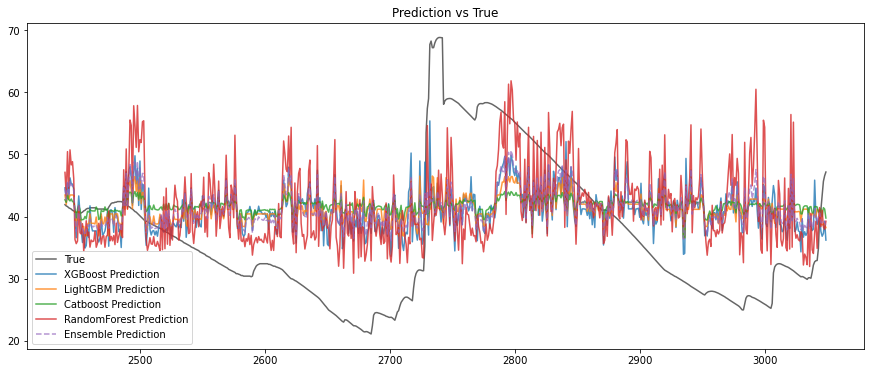

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# RMSE 계산 함수 정의
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 예측값과 실제값 비교를 위한 데이터프레임 생성
results = pd.DataFrame({
    'True': y_test,
    'XGBoost Prediction': xgb_pred,
    'LightGBM Prediction': lgbm_pred,
    'Catboost Prediction' : cat_pred,
    'RandomForest Prediction' : rf_pred,
    'Ensemble Prediction': ensemble_pred
})

# RMSE 계산
xgb_rmse = rmse(y_test, xgb_pred)
lgbm_rmse = rmse(y_test, lgbm_pred)
cat_rmse = rmse(y_test, cat_pred)
rf_rmse = rmse(y_test, rf_pred)
ensemble_rmse = rmse(y_test, ensemble_pred)

print(f"RMSE for XGBoost: {xgb_rmse:.4f}")
print(f"RMSE for LightGBM: {lgbm_rmse:.4f}")
print(f"RMSE for Catboost: {cat_rmse:.4f}")
print(f"RMSE for Catboost: {cat_rmse:.4f}")
print(f"RMSE for Ensemble: {ensemble_rmse:.4f}")

# 시각화
plt.figure(figsize=(15, 6))

plt.plot(results['True'], label='True', color='black', alpha=0.6)
plt.plot(results['XGBoost Prediction'], label='XGBoost Prediction', alpha=0.8)
plt.plot(results['LightGBM Prediction'], label='LightGBM Prediction', alpha=0.8)
plt.plot(results['Catboost Prediction'], label='Catboost Prediction', alpha=0.8)
plt.plot(results['RandomForest Prediction'], label='RandomForest Prediction', alpha=0.8)
plt.plot(results['Ensemble Prediction'], label='Ensemble Prediction', linestyle='dashed', alpha=0.7)
plt.title("Prediction vs True")
plt.legend()
plt.show()


RMSE between True values and Ensemble Predictions on Test Set: 11.4039


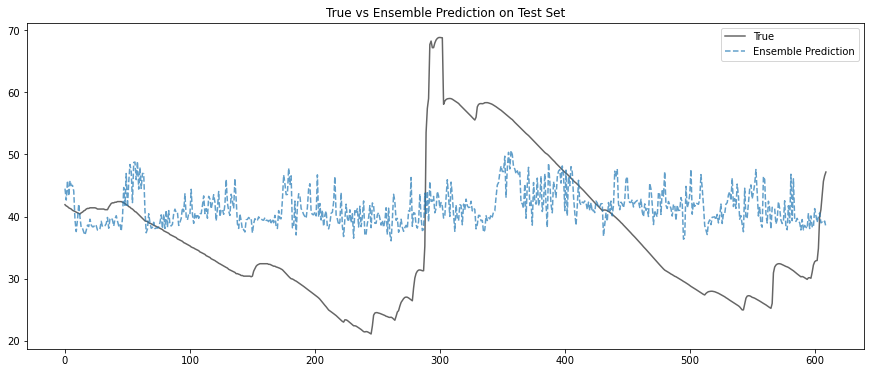

In [67]:
from sklearn.metrics import mean_squared_error

# RMSE 계산
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
print(f"RMSE between True values and Ensemble Predictions on Test Set: {ensemble_rmse:.4f}")

# 그래프로 표현
plt.figure(figsize=(15, 6))

plt.plot(y_test.reset_index(drop=True), label='True', color='black', alpha=0.6)
plt.plot(ensemble_pred, label='Ensemble Prediction', linestyle='dashed', alpha=0.7)
plt.title("True vs Ensemble Prediction on Test Set")
plt.legend()
plt.show()


In [68]:
# 예측값과 실제값 비교를 위한 데이터프레임 생성
results_test_df = pd.DataFrame({
    'True Values': y_test.values,
    'Ensemble Predictions': ensemble_pred
})

# 처음 20개 데이터를 출력해보겠습니다.
print(results_test_df.head(100))


    True Values  Ensemble Predictions
0         41.90             44.487661
1         41.70             42.648848
2         41.60             45.760553
3         41.40             43.313034
4         41.30             45.763532
..          ...                   ...
95        35.80             40.770563
96        35.71             43.647817
97        35.60             39.920422
98        35.50             39.446244
99        35.40             40.458288

[100 rows x 2 columns]


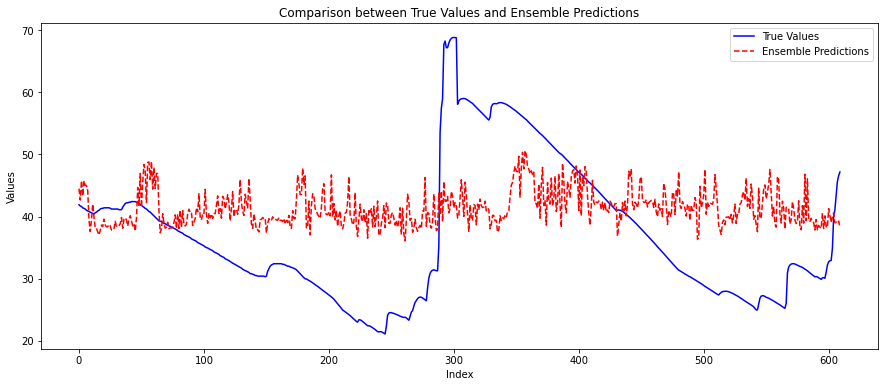

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# 실제 값과 앙상블 예측값을 그래프에 표시
plt.plot(results_test_df['True Values'], label='True Values', color='blue')
plt.plot(results_test_df['Ensemble Predictions'], label='Ensemble Predictions', color='red', linestyle='dashed')

# 그래프 제목 및 라벨 설정
plt.title('Comparison between True Values and Ensemble Predictions')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# 그래프 출력
plt.show()


In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0 # MAPE는 실제값이 0일 때 무한대가 되므로 이를 방지하기 위함임.
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

# 계산
mae = mean_absolute_error(results_test_df['True Values'], results_test_df['Ensemble Predictions'])
mape = mean_absolute_percentage_error(results_test_df['True Values'], results_test_df['Ensemble Predictions'])
mse = mean_squared_error(results_test_df['True Values'], results_test_df['Ensemble Predictions'])
rmse = np.sqrt(mse)
rmsle = np.sqrt(mean_squared_log_error(results_test_df['True Values'], results_test_df['Ensemble Predictions']))
r2 = r2_score(results_test_df['True Values'], results_test_df['Ensemble Predictions'])

# 출력
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Root Mean Squared Log Error (RMSLE): {rmsle}")
print(f"R squared (R^2): {r2}")


Mean Absolute Error (MAE): 9.737279481048565
Mean Absolute Percentage Error (MAPE): 29.87283043063827%
Mean Squared Error (MSE): 130.04934855242809
Root Mean Squared Error (RMSE): 11.40391812283954
Root Mean Squared Log Error (RMSLE): 0.29979575137999315
R squared (R^2): -0.0748427430618277


R^2: -0.0748


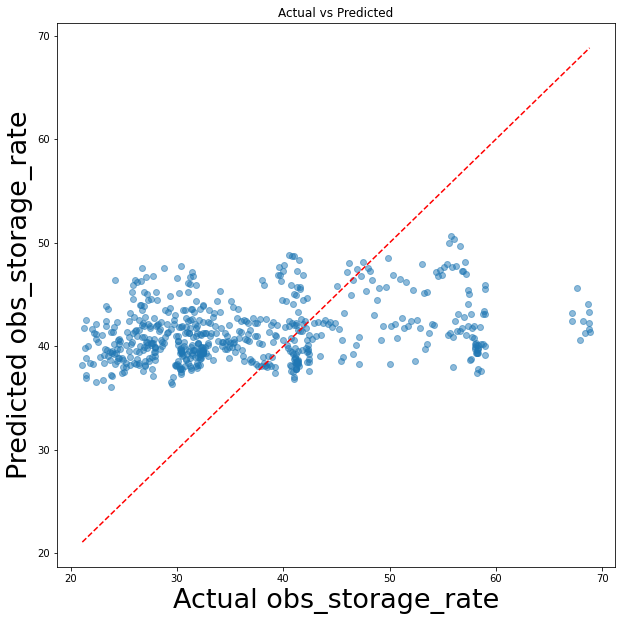

In [71]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# R^2 계산
r2 = r2_score(results_test_df['True Values'], results_test_df['Ensemble Predictions'])
print(f"R^2: {r2:.4f}")

# Scatter plot 그려주기
plt.figure(figsize=(10,10))
plt.scatter(results_test_df['True Values'], results_test_df['Ensemble Predictions'], alpha=0.5)
plt.plot([results_test_df['True Values'].min(), results_test_df['True Values'].max()], 
         [results_test_df['True Values'].min(), results_test_df['True Values'].max()], 'r--')
plt.xlabel('Actual obs_storage_rate', fontsize=27)
plt.ylabel('Predicted obs_storage_rate', fontsize=27)
plt.title('Actual vs Predicted')
plt.show()


In [72]:
# 최적의 alpha 값을 찾기 위한 grid search.
alphas = np.linspace(0.01, 1, 100)  # 0.01부터 1까지 100개의 alpha 값
best_alpha = alphas[0]
min_rmse = float('inf')

for alpha in alphas:
    ensemble_pred_ewm_current = pd.Series(ensemble_pred).ewm(alpha=alpha).mean().values
    rmse_current = np.sqrt(mean_squared_error(y_test, ensemble_pred_ewm_current))
    if rmse_current < min_rmse:
        min_rmse = rmse_current
        best_alpha = alpha

print(f"Best alpha: {best_alpha:.4f}")
print(f"Minimum RMSE with best alpha: {min_rmse:.4f}")

Best alpha: 0.3000
Minimum RMSE with best alpha: 11.2977


RMSE between True values and EWMA Ensemble Predictions on Test Set: 11.5369


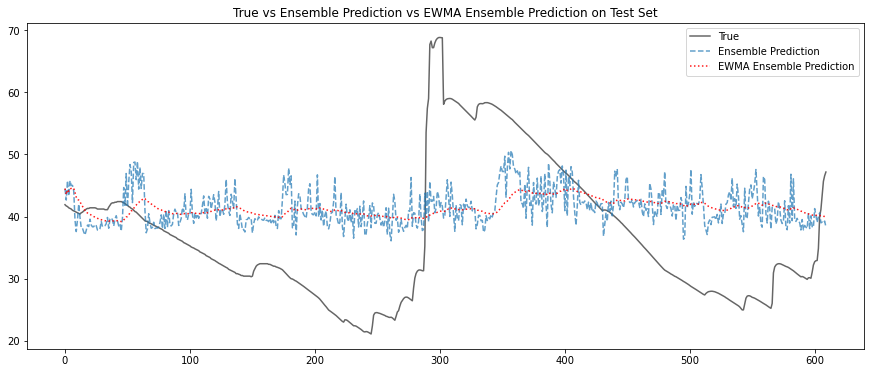

In [73]:
# 지수 가중 이동 평균 적용
alpha = 0.04 
ensemble_pred_ewm = pd.Series(ensemble_pred).ewm(alpha=alpha).mean().values

# RMSE for EWMA predictions
ensemble_ewm_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred_ewm))
print(f"RMSE between True values and EWMA Ensemble Predictions on Test Set: {ensemble_ewm_rmse:.4f}")

# 그래프로 표현
plt.figure(figsize=(15, 6))
plt.plot(y_test.reset_index(drop=True), label='True', color='black', alpha=0.6)
plt.plot(ensemble_pred, label='Ensemble Prediction', linestyle='dashed', alpha=0.7)
plt.plot(ensemble_pred_ewm, label='EWMA Ensemble Prediction', linestyle='dotted', alpha=0.9, color='red')
plt.title("True vs Ensemble Prediction vs EWMA Ensemble Prediction on Test Set")
plt.legend()
plt.show()

In [74]:
# R^2 value for EWMA predictions with span
ensemble_ewm_span_r2 = r2_score(y_test, ensemble_pred_ewm)
print(f"R^2 score between True values and EWMA Ensemble Predictions with span on Test Set: {ensemble_ewm_span_r2:.4f}")

# RMSE for EWMA predictions with span
ensemble_ewm_span_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred_ewm))
print(f"RMSE between True values and EWMA Ensemble Predictions with span on Test Set: {ensemble_ewm_span_rmse:.4f}")

R^2 score between True values and EWMA Ensemble Predictions with span on Test Set: -0.1001
RMSE between True values and EWMA Ensemble Predictions with span on Test Set: 11.5369
